In [15]:
using Pkg
Pkg.activate("../")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [16]:
using StatsBase, Distributions, Plots, LinearAlgebra, Plots

In [17]:
using Revise

includet("../src/ESGModels/msvar.jl")
includet("../src/ESGModels/msvar_gibs.jl")
includet("../src/ESGModels/msvar_simulate.jl") 

In [18]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [-.02 .4 .25; .045 .15 .43]
Σ2 = cor2cov([1 .35; .35 1], [.18, .035])

Β = [Β1, Β2]
Σ = [Σ1, Σ2]

transition_matrix = [.85 .15;.2 .8]

states_zero = [.6, .4]
X = [.12, .06]



n_steps = 50
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, Β, Σ, X, n_steps, 1)[:,:,1]'

50×2 adjoint(::Matrix{Float64}) with eltype Float64:
  0.166709   0.0410744
  0.298167   0.124394
  0.298119   0.168925
  0.228595   0.142526
  0.160904   0.0901421
  0.167464   0.115921
  0.198857   0.0992299
  0.162201   0.0779119
  0.224906   0.0923585
  0.188421   0.10829
  ⋮          
  0.27737    0.101971
  0.207872   0.131591
  0.319655   0.162937
  0.261556   0.147532
  0.157264   0.124574
  0.26247    0.173926
  0.313173   0.113342
 -0.0186635  0.108235
  0.152519   0.123789

In [19]:
Y = collect(test_returns[2:end,:])
T = n_steps-1
p = 1
X = hcat(ones(T), test_returns[p:end-1,:])
k= 2 #n_regimes
n_variables = 2
Β = [Β1, Β2]
Σ = [Σ1, Σ2]

2-element Vector{Matrix{Float64}}:
 [0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009]
 [0.0324 0.002205; 0.002205 0.0012250000000000002]

In [20]:
r = 2
display("regime count")
display(count(x -> x==r, test_regimes)/n_steps)

Ym = filter_X(Y, test_regimes[2:end], r)
Xm = filter_X(X, test_regimes[2:end], r)
Beta_mean = inv(Xm' * Xm) * Xm' * Ym
display(Beta_mean') 

display("true beta")
display(Β[r])

"regime count"

0.1

2×3 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.281314     0.966315  1.95126
 -0.00869048  -0.126278  1.09842

"true beta"

2×3 Matrix{Float64}:
 -0.02   0.4   0.25
  0.045  0.15  0.43

In [21]:
n = 5000
k= 2 #n regimes

states = zeros(Int64, n, T)
t_m = zeros(n, 2, 2)

states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
t_m[1, :, :] = sample_transition_matrix(states[1, :], k)

for s in 2:n
    states_zero = unconditional_regimes(t_m[s-1, :, :])
    states[s, :] = simulate_regimes(Y, X, Β, Σ, transition_matrix, states_zero)
    t_m[s, :, :] = sample_transition_matrix(states[s, :], k)    
end 

r1 = [count(x -> x ==1, states[:,t]) for t in 1:n_steps-1] / n
display(r1)
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

49-element Vector{Float64}:
 0.7592
 0.8654
 0.9376
 0.9656
 0.9696
 0.9762
 0.9822
 0.9766
 0.9724
 0.962
 ⋮
 0.9436
 0.9416
 0.9046
 0.9226
 0.8798
 0.7098
 0.4792
 0.2516
 0.5468

"transition matrix"

2×2 Matrix{Float64}:
 0.916337  0.0836625
 0.339494  0.660506

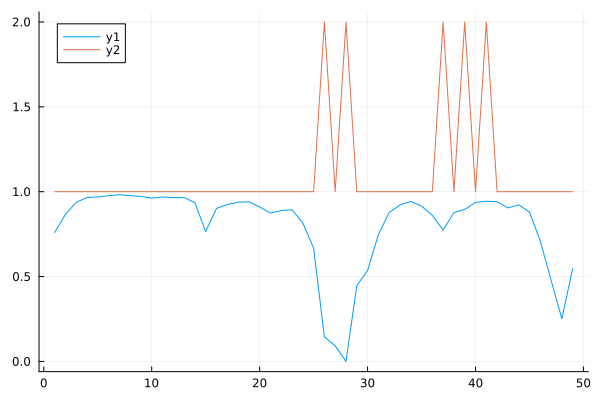

In [22]:
plot(r1)
plot!(test_regimes[2:end])

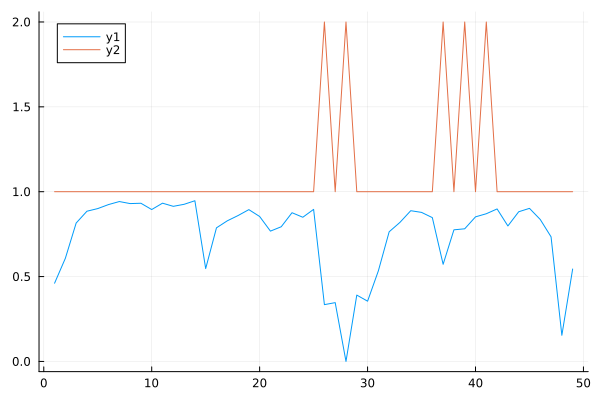

In [30]:
states_zero = [.6, .4]
regimes_probs = hamilton_filter(Y,X, Β, Σ, transition_matrix, states_zero)

plot(regimes_probs[:,1])
plot!(test_regimes[2:end])

In [24]:
n_burn = 10_000
n_sample = 2000
n = 2
Β0 = (inv(transpose(X) * X) * transpose(X) * Y)
Σ0 = transpose((Y -  X * Β0)) * (Y -  X * Β0) / (T- n -1)

tm0 = [.9 .1; .1 .9]

regimes, t_m, Β_post, Σ_post = msvar(Y, X, transition_matrix, [Β0', Β0'], [Σ0, Σ0], n_burn, n_sample)

PosDefException: PosDefException: matrix is not positive definite; Factorization failed.

In [25]:
r1 = [count(x -> x ==1, regimes[:,t]) for t in 1:n_steps-1] / n_sample

plot(r1)
plot!(test_regimes)

UndefVarError: UndefVarError: `regimes` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [26]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"transition matrix"

2×2 Matrix{Float64}:
 0.916337  0.0836625
 0.339494  0.660506

"coefficients"

"regime one"

UndefVarError: UndefVarError: `Β_post` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [27]:
mean(map(x -> x[1],sp))

UndefVarError: UndefVarError: `sp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [28]:
mat = [1 2 3; 4 5 6]

eachcol(mat)

3-element ColumnSlices{Matrix{Int64}, Tuple{Base.OneTo{Int64}}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}:
 [1, 4]
 [2, 5]
 [3, 6]